# Proton Titration of a Rigid Body in Explicit Salt Solution

This will simulate proton equilibria in a rigid body composed of particles in a spherical simulation container. We use a continuum solvent and explicit, soft spheres for salt particles which are treated grand canonically. During simulation, titratable sites are updated with swap moves according to input pH.


### System Requirements
This Jupyter Notebook was originally run in MacOS 10.11 with `GCC 4.8`, `Python2`, `matplotlib`, `pandas` within the Anaconda environment. Contemporary Linux distributions such as Ubuntu 14.04 should work as well.

### Download and build Faunus

We use a custom Metropolis Monte Carlo (MC) program build within the [Faunus framework](http://github.com/mlund/faunus.git). The sections below will fetch the complete faunus project and compile the program.

In [1]:
from __future__ import division, unicode_literals, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, filecmp, copy
from pathlib import Path
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir
print(workdir)

/Volumes/SimulationData/maxim/titration-tapasin


In [3]:
%%bash -s "$workdir"
%cd $1

if [ ! -d "faunus" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout 86a1f74
    git apply ../titrate.diff
else
    cd faunus
fi

# if different, copy custom gctit.cpp into faunus
if ! cmp ../titrate.cpp src/examples/gctit.cpp
then
    cp ../titrate.cpp src/examples/gctit.cpp
fi
pwd
cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on &>/dev/null
make example_gctit -j4

/Volumes/SimulationData/maxim/titration-tapasin/faunus
[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target example_gctit


bash: line 1: fg: no job control


### Let's coarse grain an atomic PDB structure to the amino acid level

For this purpose we use the module `pytraj` and also locate possible disulfide bonds as these should not be allowed to titrate. Note that if found, the residues in the generated `.aam` file should be manually renamed to prevent them from being regarded as titratable. Likewise, the N and C terminal ends need to be handled manually.

In [4]:
%cd $workdir
import mdtraj as md

traj = md.load_pdb('tpn271.pdb')
for chain in traj.topology.chains:
    print('chain: ', chain.index)
    
    # filter pdb to only select protein(s)
    sel = chain.topology.select('protein')
    top = chain.topology.subset(sel)
    f = open('chain'+str(chain.index)+'.aam','w')
    f.write(str(top.n_residues)+'\n')
    
    # locate disulfide bonds (not used for anything yet)
    for b in top.bonds:
        i = b[0].residue.index
        j = b[1].residue.index
        if j>i+1:
            if (b[0].residue.name == 'CYS'):
                if (b[1].residue.name == 'CYS'):
                    print('SS-bond between residues', i, j)
        
    # loop over residues and calculate residue mass centers, radius, and weight
    top.create_disulfide_bonds( traj.xyz[0] )
    for res in top.residues:
        if res.is_protein:
            cm = [0,0,0] # residue mass center
            mw = 0       # residue weight
            for a in res.atoms:
                cm = cm + a.element.mass * traj.xyz[0][a.index]
                mw = mw + a.element.mass
            cm = cm/mw*10
            radius = ( 3./(4*np.pi)*mw/1.0 )**(1/3.)
            f.write('{0:4} {1:5} {2:8.3f} {3:8.3f} {4:8.3f} {5:6.3f} {6:6.2f} {7:6.2f}\n'\
                    .format(res.name,res.index,cm[0],cm[1],cm[2],0,mw,radius))
    f.close()

/Volumes/SimulationData/maxim/titration-tapasin
chain:  0


### Create Input and run MC simulation

In [5]:
pH_range       = np.arange(3,13,0.25).tolist()
salt_range     = [0.05, 0.15] # mol/l

In [7]:
%cd -q $workdir

def mkinput():
    js = {
        "energy": {
            "eqstate": { "processfile": "titrate.json" },
            "nonbonded": {
                "coulomb": { "epsr": 80 }
            }
        },

        "system": {
            "temperature": 298.15,
            "sphere" : { "radius" : 90 },
            "mcloop": { "macro": 10, "micro": micro }
        },

        "moves": {
            "gctit"         : { "molecule": "salt", "prob": 0.5 },
            "atomtranslate" : {
                "salt":  { "prob": 0.5 }
            }
        },

        "moleculelist": {
            "protein":  { "structure":"../chain0.aam", "Ninit":1, "insdir":"0 0 0"},
            "salt": {"atoms":"Na Cl", "Ninit":60, "atomic":True }
        },

        "atomlist" : {
            "Na"   :  { "q": 1, "r":1.9, "eps":0.005, "mw":22.99, "dp":100, "activity":salt },
            "Cl"   :  { "q":-1, "r":1.7, "eps":0.005, "mw":35.45, "dp":100, "activity":salt },
            "ASP"  :  { "q":-1, "r":3.6, "eps":0.05, "mw":110 },
            "HASP" :  { "q":0,  "r":3.6, "eps":0.05, "mw":110 },
            "LASP" :  { "q":2,  "r":3.6, "eps":0.05, "mw":110 },
            "CTR"  :  { "q":-1, "r":2.0, "eps":0.05, "mw":16 },
            "HCTR" :  { "q":0,  "r":2.0, "eps":0.05, "mw":16 },
            "GLU"  :  { "q":-1, "r":3.8, "eps":0.05, "mw":122 },
            "HGLU" :  { "q":0,  "r":3.8, "eps":0.05, "mw":122 },
            "LGLU" :  { "q":2,  "r":3.8, "eps":0.05, "mw":122 },
            "HIS"  :  { "q":0,  "r":3.9, "eps":0.05, "mw":130 },
            "HHIS" :  { "q":1,  "r":3.9, "eps":0.05, "mw":130 },
            "NTR"  :  { "q":0,  "r":2.0, "eps":0.05, "mw":14 },
            "HNTR" :  { "q":1,  "r":2.0, "eps":0.05, "mw":14 },
            "TYR"  :  { "q":-1, "r":4.1, "eps":0.05, "mw":154 },
            "HTYR" :  { "q":0,  "r":4.1, "eps":0.05, "mw":154 },
            "LYS"  :  { "q":0,  "r":3.7, "eps":0.05, "mw":116 },
            "HLYS" :  { "q":1,  "r":3.7, "eps":0.05, "mw":116 },
            "CYb"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":103 },
            "CYS"  :  { "q":-1, "r":3.6, "eps":0.05, "mw":103 },
            "HCYS" :  { "q":0,  "r":3.6, "eps":0.05, "mw":103 },
            "ARG"  :  { "q":0,  "r":4.0, "eps":0.05, "mw":144 },
            "HARG" :  { "q":1,  "r":4.0, "eps":0.05, "mw":144 },
            "ALA"  :  { "q":0,  "r":3.1, "eps":0.05, "mw":66 },
            "ILE"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":102 },
            "LEU"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":102 },
            "MET"  :  { "q":0,  "r":3.8, "eps":0.05, "mw":122 },
            "PHE"  :  { "q":0,  "r":3.9, "eps":0.05, "mw":138 },
            "PRO"  :  { "q":0,  "r":3.4, "eps":0.05, "mw":90 },
            "TRP"  :  { "q":0,  "r":4.3, "eps":0.05, "mw":176 },
            "VAL"  :  { "q":0,  "r":3.4, "eps":0.05, "mw":90 },
            "SER"  :  { "q":0,  "r":3.3, "eps":0.05, "mw":82 },
            "THR"  :  { "q":0,  "r":3.5, "eps":0.05, "mw":94 },
            "ASN"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":108 },
            "GLN"  :  { "q":0,  "r":3.8, "eps":0.05, "mw":120 },
            "GLY"  :  { "q":0,  "r":2.9, "eps":0.05, "mw":54 }
        },

        "processes" : {
            "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
            "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
            "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
            "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
            "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
            "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
            "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
            "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
            "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH }
        }
    }

    with open('titrate.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

d = {}
if not Path('titrate.p').is_file():
    for salt in salt_range:
        d[salt] = {}
        for pH in pH_range:
            pfx='pH'+str(pH)+'-I'+str(salt)
            if not os.path.isdir(pfx):
                %mkdir -p $pfx 
                %cd $pfx

                # equilibration run (no translation)
                !rm -fR state
                micro=5000
                mkinput()
                !../faunus/src/examples/gctit > eq

                # production run
                micro=50000
                mkinput()
                !../faunus/src/examples/gctit > out
                %cd -q ..
            if os.path.isdir(pfx):
                %cd -q $pfx
                Z    = !cat out | grep protein | tail -n 1 | gawk '{print $2}'
                C    = !cat out | grep protein | tail -n 1 | gawk '{print $3}'
                mu   = !cat out | grep protein | tail -n 1 | gawk '{print $4}'
                zabs = !cat out | grep protein | tail -n 1 | gawk '{print $6}'
                combined = Z + C + mu + zabs
                combined = [float(i) for i in combined] # convert str to float
                d[salt][pH] = pd.Series(combined, index=['Z','C','mu','zabs'])
                %cd -q ..
        d[salt] = pd.DataFrame( d[salt] ).T
    %cd -q ..
    d = pd.Series(d)
    d.to_pickle('titrate.p')
print('done.')

done.


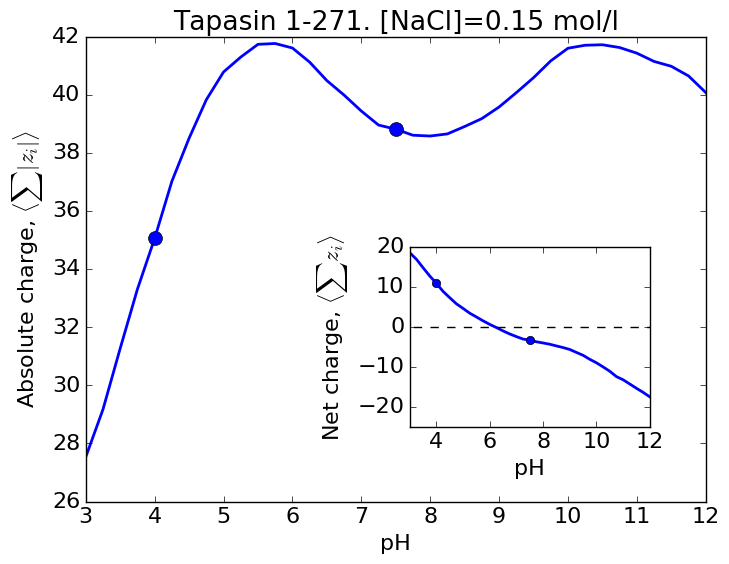

In [12]:
%cd -q $workdir
if Path('titrate.p').is_file():
    d = pd.read_pickle('titrate.p')

    charge = d[0.15].Z
    zabs = d[0.15].zabs
    markers_on = [int(round(i)) for i in [ (4-3)/0.25, (7.4-3)/0.25]]
    plt.title('Tapasin 1-271. [NaCl]=0.15 mol/l')
    plt.plot(zabs.index, zabs.values, '-bo', lw=2, markevery=markers_on, ms=10)
    plt.xlabel('pH')
    plt.ylabel(r'Absolute charge, $\langle \sum |z_i| \rangle$')
    plt.xlim(3,12)

    # this is an inset axes over the main axes
    a = plt.axes([.53, .25, .3, .3], axisbg='w')
    plt.plot(charge.index, charge.values, '-bo', lw=2, markevery=markers_on)
    plt.plot([0,14],[0,0], 'k--')
    plt.xticks([4,6,8,10,12])
    plt.yticks([-20,-10,0, 10, 20])
    plt.xlabel('pH')
    plt.xlim(3,12)
    plt.ylabel(r'Net charge, $\langle \sum z_i \rangle$')

    plt.savefig('fig.pdf')